In [1]:
import numpy as np
import pandas as pd
import torch

from fastai.text import language_model_learner, AWD_LSTM, text_classifier_learner, \
                        TextDataBunch, pad_collate, Learner
from fastai.text.data import TextLMDataBunch, load_data, TextClasDataBunch, DatasetType, TextList
from fastai.text.transform import Vocab, BaseTokenizer, Tokenizer
from fastai.callbacks import SaveModelCallback
from fastai.torch_core import partial
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification

import re
import pickle

from sklearn.metrics import f1_score

from typing import List

torch.cuda.set_device('cuda:1')

In [2]:
data = pd.read_csv('data/Tweets.csv')

In [3]:
def process_text(text):
    """
    - replace http link with ulmfit style token xxlink
    - first token will be thrown as model can become biased because of disbalances
        in class destribution through companies
    """
    text = re.sub('http[:\.\w\d/_]+', 'xxlink', text)
    text = ' '.join(text.split(' ')[1:])
    return text

# ULMFIT

## LM finetuning

In [3]:
lm_df = pd.DataFrame()
lm_df['text'] = data['text']

In [5]:
lm_df['text'] = lm_df['text'].apply(lambda x: process_text(x))

In [6]:
lm_df.head()

,text
0,What @dhepburn said.
1,plus you've added commercials to the experienc...
2,I didn't today... Must mean I need to take ano...
3,"it's really aggressive to blast obnoxious ""ent..."
4,and it's a really big bad thing about it


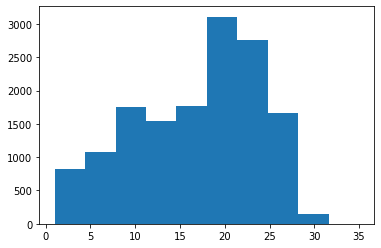

In [7]:
lens = [len(text.split(' ')) for text in lm_df['text']]
plt.hist(lens);

In [8]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
train_lm, val_lm = train_test_split(lm_df, stratify=data[['airline_sentiment', 'airline']], random_state=21)

In [10]:
data_lm = TextLMDataBunch.from_df('ulmfit', 
                                  train_lm,
                                  val_lm,
                                  text_cols='text')

In [11]:
data_lm.show_batch()

idx,text
0,"was due to a xxunk and xxunk decision to xxunk other plane before the xxunk were done . # fail . xxbos sent xxup dm last week , re : suit regarding your error . xxmaj no response was given . xxmaj please xxmaj answer xxup dm or tell me who to send suit to xxrep 4 . xxbos # destinationdragons id is my favorite band and i met my"
1,"'s up with flight xxunk no gate agent or plane at xxup phx xxup xxunk ? xxmaj nice customer service . xxbos xxup and they xxmaj cancelled xxmaj flighted my flight and left me with no help to find a hotel to stay in . i slept in an airport for a night-_- xxbos xxunk news , time to raise the bar on legroom ! xxlink xxbos flight xxup xxunk"
2,checked through to xxmaj cancelled xxmaj flightled flight 362 . xxmaj when will they arrive in xxup mke ? xxmaj not much help from xxunk staff . xxmaj xxunk in xxup dfw xxbos @airbus xxmaj wow what an amazing video xxlink xxmaj great world xxmaj guys # xxmaj bluemanity # corevalues # xxmaj passion # aerojobmarket xxbos what 's up w flt 4 ? xxmaj brothers fiancé sitting on board
3,i will make sure to never use your incompetent airlines again . xxmaj my luggage has been out for delivery for 24 hours . xxbos your airline should have a better system to xxmaj inform your clients when their flights are xxmaj cancelled xxmaj flightled last min . 😒 👺 we have schedules too xxbos are people in an exit row still supposed to give their verbal xxunk ? i
4,lax xxbos flight 3056 still sitting at xxup dfw waiting for baggage to be loaded xxbos @rizzilient i booked tickets using miles and need to change the dates . xxmaj have been trying to get to an advantage rep 4 two days xxbos yeah you guys just told me to call the website that i booked from . i booked on your website . xxup unacceptable xxbos xxunk but i


In [13]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
learner.freeze_to(-1)

In [15]:
learner.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.838850,4.267463,0.230616,00:06


In [16]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.143960,3.984435,0.261901,00:07


In [17]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.864756,3.907271,0.270265,00:08


In [20]:
save_callback = SaveModelCallback(learner, name='best_lm')

learner.unfreeze()
learner.fit_one_cycle(7, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[save_callback])

epoch,train_loss,valid_loss,accuracy,time
0,3.647753,3.889118,0.272639,00:08
1,3.632224,3.871666,0.273813,00:08
2,3.590812,3.856251,0.274883,00:08
3,3.523906,3.849570,0.276527,00:08
4,3.456951,3.847380,0.276257,00:08
5,3.405072,3.847212,0.276880,00:08
6,3.386902,3.847677,0.276762,00:08


Better model found at epoch 0 with valid_loss value: 3.8891184329986572.
Better model found at epoch 1 with valid_loss value: 3.8716659545898438.
Better model found at epoch 2 with valid_loss value: 3.8562514781951904.
Better model found at epoch 3 with valid_loss value: 3.84956955909729.
Better model found at epoch 4 with valid_loss value: 3.847379684448242.
Better model found at epoch 5 with valid_loss value: 3.847212076187134.


In [25]:
learner.load('best_lm');

In [31]:
learner.save_encoder('lm_encoder')
data_lm.train_ds.vocab.save('ulmfit/models/ulmfit_vocab')

In [73]:
learner.predict('I want to buy')

'I want to buy tickets'

# Training a classifier

In [4]:
cls_df = data.copy()

In [5]:
cls_df['text'] = cls_df['text'].apply(lambda x: process_text(x))

In [6]:
label_dict = dict(
    negative=-1,
    neutral=0,
    positive=1
)

In [7]:
cls_df['label'] = cls_df['airline_sentiment'].apply(lambda x: label_dict[x])

In [8]:
# the same splitting as for baseline
train_df, test_df = train_test_split(cls_df, test_size=0.2, stratify=data[['airline_sentiment', 'airline']],
                               random_state=21)

In [9]:
# the same splitting as in flair notebook
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df[['airline_sentiment', 'airline']],
                               random_state=21)

In [10]:
train_df = train_df[['text', 'label']]
val_df = val_df[['text', 'label']]
test_df = test_df[['text', 'label']]

In [11]:
train_df.head()

,text,label
8938,Got flight reschedule to flight form PIT to FL...,-1
1935,more lies... xxlink,-1
5517,I'm on the 10:55 flight! Everyone has been so ...,1
2030,you have Cancelled Flightled my flight UA922 f...,-1
13916,because you won't get our bags for us because ...,-1


In [12]:
itos = pickle.load(open('ulmfit/models/ulmfit_vocab', 'rb'))
vocab = Vocab(itos)

In [13]:
data_class = TextClasDataBunch.from_df('ulmfit', train_df, val_df, test_df,
                                       vocab=vocab,
                                       text_cols='text', label_cols='label')

In [14]:
data_class.show_batch()

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,1
xxbos xxmaj hi . i have xxup koa - xxup lax - xxup phl - xxup ord booked as a 1-way xxunk xxunk . xxmaj if i called to chnge it to xxup koa - xxup lax - xxup phx - xxup ord would i have to pay any fees,0
"xxbos xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and xxunk on xxup xxunk ?",0
xxbos xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),1
xxbos xxup poor xxup experience 2day at ord xxunk . 8 emp . w / 3 cust . 10 waiting . xxmaj asked to speak w / supervisor . xxmaj told 20 min . xxmaj in a mtg ! ! xxmaj what ? ! ? !,-1


In [15]:
learner = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learner.load_encoder('lm_encoder')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


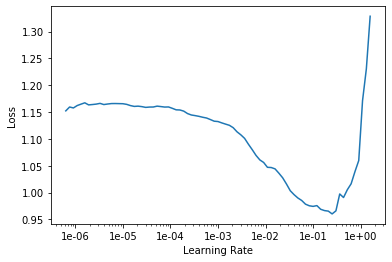

In [16]:
learner.lr_find()
learner.recorder.plot()

In [17]:
learner.freeze_to(-1)
learner.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.668806,0.560360,0.764940,00:04


In [18]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.648429,0.531555,0.791690,00:04


In [19]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.561115,0.485385,0.804781,00:08


In [21]:
save_callback = SaveModelCallback(learner, name='best_classifier')

learner.unfreeze()
learner.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7), callbacks=[save_callback])

epoch,train_loss,valid_loss,accuracy,time
0,0.502606,0.476347,0.807627,00:09
1,0.493750,0.471252,0.810472,00:09
2,0.466647,0.464841,0.813887,00:10
3,0.480212,0.471894,0.814456,00:09
4,0.425220,0.466780,0.809903,00:09
5,0.361998,0.484932,0.819010,00:09
6,0.332047,0.492146,0.815595,00:10
7,0.322926,0.505198,0.819010,00:10
8,0.293523,0.497840,0.814456,00:09
9,0.294395,0.506887,0.814456,00:09


Better model found at epoch 0 with valid_loss value: 0.4763467609882355.
Better model found at epoch 1 with valid_loss value: 0.47125181555747986.
Better model found at epoch 2 with valid_loss value: 0.4648410975933075.


In [25]:
val_preds, val_labels = learner.get_preds(DatasetType.Valid, ordered=True)
val_preds = val_preds.argmax(dim=1).data.cpu().numpy()
val_labels = val_labels.data.cpu().numpy()
f1_score(val_preds, val_labels, average='macro'), f1_score(val_preds, val_labels, average='micro')

(0.7453804054346339, 0.8138873079112123)

<b> At least ULMFIT outperformed baseline. But again not very much <b>

In [26]:
test_preds, _ = learner.get_preds(DatasetType.Test, ordered=True)
test_preds = test_preds.argmax(dim=1).data.cpu().numpy()
test_labels = np.array(test_df['label'])
f1_score(val_preds, val_labels, average='macro'), f1_score(val_preds, val_labels, average='micro')

(0.7453804054346339, 0.8138873079112123)

# BERT

## Data preperation

In [5]:
cls_df = data.copy()
cls_df['label'] = cls_df['airline_sentiment']

In [6]:
cls_df['text'] = cls_df['text'].apply(lambda x: process_text(x))

In [9]:
# the same splitting as for baseline
train_df, test_df = train_test_split(cls_df, test_size=0.2, stratify=data[['airline_sentiment', 'airline']],
                               random_state=21)

In [10]:
# the same splitting as in flair notebook
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df[['airline_sentiment', 'airline']],
                               random_state=21)

In [11]:
train_df = train_df[['text', 'label']]
val_df = val_df[['text', 'label']]
test_df = test_df[['text', 'label']]

In [12]:
train_df.head()

,text,label
8938,Got flight reschedule to flight form PIT to FL...,negative
1935,more lies... xxlink,negative
5517,I'm on the 10:55 flight! Everyone has been so ...,positive
2030,you have Cancelled Flightled my flight UA922 f...,negative
13916,because you won't get our bags for us because ...,negative


## Training a classifier

In [13]:
config = dict(
    is_test=False,
    
    bert_model='bert-base-cased',
    max_seq_len=128,
    bs=16,
    use_fp16=True,
    max_lr=1e-5,
)

In [14]:
if config['is_test']:
    train_df = train_df.head(1024)
    val_df = val_df.head(1024)
    test_df = test_df.head(1024)

In [15]:
bert_tok = BertTokenizer.from_pretrained(config['bert_model'], do_lower_case=False)

In [16]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [17]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config['max_seq_len']), pre_rules=[], post_rules=[])
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [18]:
print(sorted(train_df['label'].unique()))
print(sorted(val_df['label'].unique()))

['negative', 'neutral', 'positive']
['negative', 'neutral', 'positive']


In [19]:
databunch = TextDataBunch.from_df(".", train_df, val_df, test_df,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="text",
                  label_cols='label',
                  bs=config['bs'],
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [20]:
# databunch.show_batch()

In [21]:
num_labels = len(train_df['label'].unique())
bert_model = BertForSequenceClassification.from_pretrained(config['bert_model'], 
                                                           num_labels=num_labels)

In [22]:
loss_func = torch.nn.CrossEntropyLoss()

In [23]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)
if config['use_fp16']: 
    learner = learner.to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


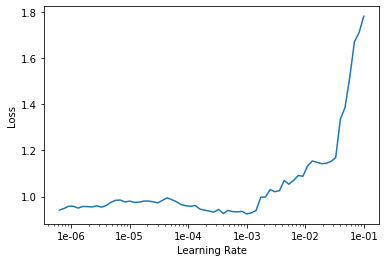

In [24]:
learner.lr_find()
learner.recorder.plot()

In [25]:
save_callback = SaveModelCallback(learner, name='best_bert_classifier_1')
learner.fit_one_cycle(5, max_lr=config['max_lr'], callbacks=[save_callback])

epoch,train_loss,valid_loss,time
0,0.528295,0.513292,02:59
1,0.410057,0.411114,03:00
2,0.304035,0.438057,03:03
3,0.221112,0.468459,03:09
4,0.151537,0.477702,03:04


Better model found at epoch 0 with valid_loss value: 0.5132917165756226.
Better model found at epoch 1 with valid_loss value: 0.4111137390136719.


In [37]:
learner.load('best_bert_classifier_1');

In [38]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds, labels = learner.get_preds(ds_type)
    preds = preds.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :], labels[reverse_sampler]

validation predictions

In [39]:
val_preds, val_labels = get_preds_as_nparray(DatasetType.Valid)

In [40]:
val_preds = np.argmax(val_preds, axis=1)
val_preds

array([0, 0, 0, 0, ..., 1, 2, 2, 2])

In [41]:
val_preds, val_labels

(array([0, 0, 0, 0, ..., 1, 2, 2, 2]), array([0, 0, 0, 0, ..., 1, 0, 1, 2]))

In [42]:
f1_score(val_preds, val_labels, average='macro'), f1_score(val_preds, val_labels, average='micro')

(0.7969406461057292, 0.842344906089926)

test predictions

In [43]:
test_preds, _ = get_preds_as_nparray(DatasetType.Test)

In [44]:
test_preds = np.argmax(test_preds, axis=1)

In [45]:
label_dict = {label: i for i, label in enumerate(learner.data.classes)}

test_labels = np.array(test_df['label'].apply(lambda x: label_dict[x]).tolist())

In [46]:
test_preds, test_labels

(array([2, 1, 2, 1, ..., 2, 0, 1, 0]), array([1, 1, 2, 1, ..., 2, 0, 1, 0]))

<b>As expected BERT gave fairly good results. It significantly outperforms baseline: + 6% to macro f1 and + 3% to micro f1

In [47]:
f1_score(test_preds, test_labels, average='macro'), f1_score(test_preds, test_labels, average='micro')

(0.7830227852064708, 0.832308743169399)